# Task 2: 3D Reconstruction [30]

**Please go through the notebook once before beginning working on it!**

In this notebook, we will extend our work from Task 1 to reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0).

#### Imports

In [2]:
!pip install open3d

^C


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares

# add imports here

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset

In [4]:
# Path to the dataset (update with the actual path)
images_path = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages"

# List all files in the directory
image_files = sorted(os.listdir(images_path))

# Helper function to check if a file is an image
def is_image_file(filename):
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

# Filter to get only valid image files (skipping the first two files)
valid_image_files = [file for file in image_files[2:] if is_image_file(file)]

In [5]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def normalize_brightness(img):
    """Normalizes the brightness of an image using histogram equalization."""
    if len(img.shape) == 2:  
        return cv2.equalizeHist(img)
    elif len(img.shape) == 3:  
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def preprocess_images(folder_pth, resize_dim=(800, 600)):
    """Loads, preprocesses, and returns images."""
    img_paths = get_img_paths(folder_pth)
    total_images = len(img_paths)
    preprocessed_images = []

    for i, path in enumerate(img_paths, start=1):
        img = cv2.imread(path)
        if img is not None:
            img = resize_image(img, size=resize_dim)  
            img = normalize_brightness(img) 
            img = convert_to_grayscale(img) 
            preprocessed_images.append(img)

        if i % 100 == 0 or i == total_images:
            print(f"Preprocessed {i}/{total_images} images")

    return preprocessed_images

Preprocessed 100/500 images
Preprocessed 200/500 images
Preprocessed 300/500 images
Preprocessed 400/500 images
Preprocessed 500/500 images


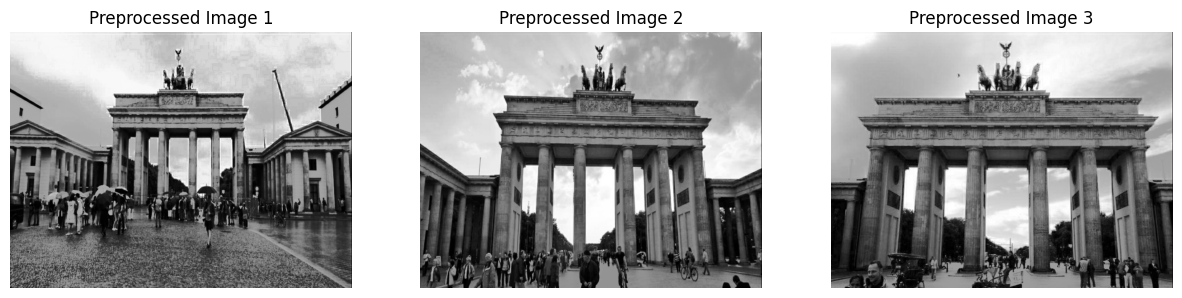

In [6]:
preprocessed_images = preprocess_images(images_path)

plt.figure(figsize=(15, 5))
for i, img in enumerate(preprocessed_images[:3]):  
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Preprocessed Image {i + 1}")
    plt.axis('off')
plt.show()

### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images.

In [7]:
import cv2
import matplotlib.pyplot as plt

def feature_detection(preprocessed_images, display_pair=(0, 1), num_best_matches=50):
    """
    Extracts features from all images, matches features across all pairs,
    filters the best matches, and displays the result for a selected pair.
    
    Parameters:
        preprocessed_images (list): List of preprocessed images.
        display_pair (tuple): Indices of the image pair to display.
        num_best_matches (int): Number of best matches to display for the selected pair.
    """
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Step 1: Detect features and compute descriptors for all images
    keypoints = []
    descriptors = []
    for image in preprocessed_images:
        kps, descs = orb.detectAndCompute(image, None)
        keypoints.append(kps)
        descriptors.append(descs)

    # Step 2: Match features across all image pairs using a brute-force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = []

    total_pairs = len(preprocessed_images) * (len(preprocessed_images) - 1) // 2
    pair_count = 0

    for i in range(len(descriptors)):
        for j in range(i + 1, len(descriptors)):
            pair_count += 1
            if pair_count % 10000 == 0 or pair_count == total_pairs:
                print(f"Processing pair {pair_count}/{total_pairs}: {pair_count*100/total_pairs}%")
            if descriptors[i] is not None and descriptors[j] is not None:
                raw_matches = bf.match(descriptors[i], descriptors[j])
                # Sort matches by distance and keep only the best ones
                sorted_matches = sorted(raw_matches, key=lambda x: x.distance)[:num_best_matches]
                matches.append(((i, j), sorted_matches))

    # Step 3: Display the results for the specified image pair
    i, j = display_pair
    image1 = preprocessed_images[i]
    image2 = preprocessed_images[j]

    kp1 = keypoints[i]
    kp2 = keypoints[j]
    best_matches = [match for pair, match in matches if pair == (i, j)][0]

    # Convert grayscale images to BGR for visualization
    image1_color = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Draw keypoints for the selected pair
    img_matches = cv2.drawMatches(
        image1_color, kp1, image2_color, kp2, best_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the image with feature matching
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Feature Matching Between Image {i+1} and Image {j+1}")
    plt.axis('off')
    plt.show()

# Example usage
# Assuming preprocessed_images is a list of preprocessed images
feature_detection(preprocessed_images, display_pair=(0, 1), num_best_matches=50)

Processing pair 10000/124750: 8.016032064128256%
Processing pair 20000/124750: 16.03206412825651%
Processing pair 30000/124750: 24.04809619238477%
Processing pair 40000/124750: 32.06412825651302%


KeyboardInterrupt: 

Processing pair 10000/124750: 8.016032064128256%
Processing pair 20000/124750: 16.03206412825651%
Processing pair 30000/124750: 24.04809619238477%
Processing pair 40000/124750: 32.06412825651302%
Processing pair 50000/124750: 40.08016032064128%
Processing pair 60000/124750: 48.09619238476954%
Processing pair 70000/124750: 56.1122244488978%
Processing pair 80000/124750: 64.12825651302605%
Processing pair 90000/124750: 72.14428857715431%
Processing pair 100000/124750: 80.16032064128257%
Processing pair 110000/124750: 88.17635270541082%
Processing pair 120000/124750: 96.19238476953907%
Processing pair 124750/124750: 100.0%


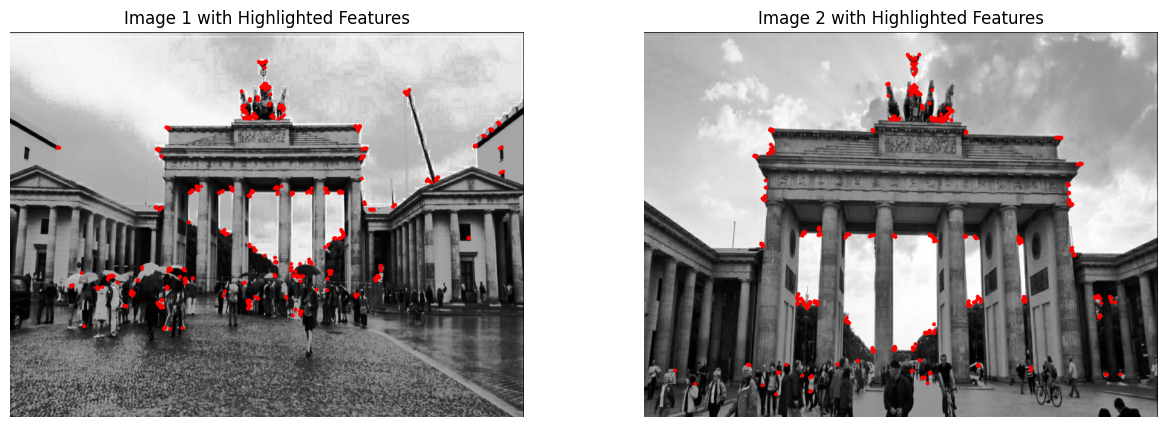

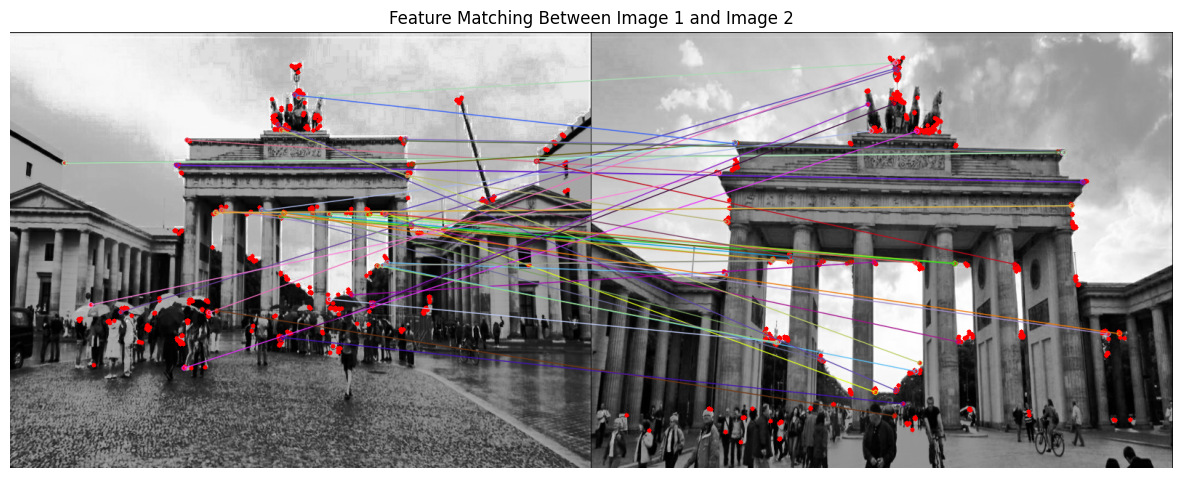

In [9]:
import cv2
import matplotlib.pyplot as plt

def feature_detection_and_matching(preprocessed_images, display_pair=(0, 1), num_best_matches=50):
    """
    Extracts features from all images, matches features across all pairs,
    filters the best matches, and displays the results for feature detection
    and matching for a selected pair.
    
    Parameters:
        preprocessed_images (list): List of preprocessed images.
        display_pair (tuple): Indices of the image pair to display.
        num_best_matches (int): Number of best matches to display for the selected pair.
    """
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Step 1: Detect features and compute descriptors for all images
    keypoints = []
    descriptors = []
    for image in preprocessed_images:
        kps, descs = orb.detectAndCompute(image, None)
        keypoints.append(kps)
        descriptors.append(descs)

    # Step 2: Match features across all image pairs using a brute-force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = []

    total_pairs = len(preprocessed_images) * (len(preprocessed_images) - 1) // 2
    pair_count = 0

    for i in range(len(descriptors)):
        for j in range(i + 1, len(descriptors)):
            pair_count += 1
            if pair_count % 10000 == 0 or pair_count == total_pairs:
                print(f"Processing pair {pair_count}/{total_pairs}: {pair_count*100/total_pairs}%")
            if descriptors[i] is not None and descriptors[j] is not None:
                raw_matches = bf.match(descriptors[i], descriptors[j])
                # Sort matches by distance and keep only the best ones
                sorted_matches = sorted(raw_matches, key=lambda x: x.distance)[:num_best_matches]
                matches.append(((i, j), sorted_matches))

    # Step 3: Display feature detection results
    i, j = display_pair
    image1 = preprocessed_images[i]
    image2 = preprocessed_images[j]

    kp1 = keypoints[i]
    kp2 = keypoints[j]

    # Convert grayscale images to BGR for visualization
    image1_color = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Highlight keypoints by drawing small red circles
    for kp in kp1:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image1_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)

    for kp in kp2:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image2_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)

    # Display the images with highlighted features
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1_color, cv2.COLOR_BGR2RGB))
    plt.title("Image 1 with Highlighted Features")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB))
    plt.title("Image 2 with Highlighted Features")
    plt.axis('off')

    plt.show()

    # Step 4: Display feature matching results
    best_matches = [match for pair, match in matches if pair == (i, j)][0]

    # Draw keypoints for the selected pair
    img_matches = cv2.drawMatches(
        image1_color, kp1, image2_color, kp2, best_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the image with feature matching
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Feature Matching Between Image {i+1} and Image {j+1}")
    plt.axis('off')
    plt.show()

# Example usage
# Assuming preprocessed_images is a list of preprocessed images
feature_detection_and_matching(preprocessed_images, display_pair=(0, 1), num_best_matches=50)

### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack.

In [10]:
!git clone --depth 1 https://github.com/colmap/colmap.git

Cloning into 'colmap'...
Updating files:  37% (303/811)
Updating files:  38% (309/811)
Updating files:  39% (317/811)
Updating files:  40% (325/811)
Updating files:  41% (333/811)
Updating files:  42% (341/811)
Updating files:  43% (349/811)
Updating files:  44% (357/811)
Updating files:  45% (365/811)
Updating files:  46% (374/811)
Updating files:  47% (382/811)
Updating files:  48% (390/811)
Updating files:  49% (398/811)
Updating files:  50% (406/811)
Updating files:  51% (414/811)
Updating files:  52% (422/811)
Updating files:  53% (430/811)
Updating files:  54% (438/811)
Updating files:  54% (445/811)
Updating files:  55% (447/811)
Updating files:  56% (455/811)
Updating files:  57% (463/811)
Updating files:  58% (471/811)
Updating files:  59% (479/811)
Updating files:  60% (487/811)
Updating files:  60% (491/811)
Updating files:  61% (495/811)
Updating files:  62% (503/811)
Updating files:  63% (511/811)
Updating files:  64% (520/811)
Updating files:  65% (528/811)
Updating files

In [ ]:
import numpy as np
import cv2
from colmap.scripts.python.read_write_model import read_cameras_binary, read_images_binary

# Paths to the COLMAP binary files
camera_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/cameras.bin"
images_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/images.bin"

# Read cameras and images from COLMAP binary files
cameras = read_cameras_binary(camera_bin_path)
images = read_images_binary(images_bin_path)

# Map to store K matrices for each image
K_matrices = {}
keypoints_all = {}
descriptors_all = {}

# Extract all image filenames and corresponding K matrices
for img_id, image in images.items():
    camera_id = image.camera_id
    camera = cameras[camera_id]
    params = camera.params
    fx, fy, cx, cy = params[:4]

    # Construct the intrinsic matrix (K)
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    K_matrices[image.name] = K

# ORB detector to extract keypoints and descriptors
orb = cv2.ORB_create()
counter = 0
# Extract features for all images
for img_id, image in images.items():
    image_path = f"../brandenburg_gate/brandenburg_gate/dense/SelectedImages/{image.name}"
    print(image_path)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        keypoints, descriptors = orb.detectAndCompute(img, None)
        keypoints_all[image.name] = keypoints
        descriptors_all[image.name] = descriptors
        print("Image read succesfully: ", counter)
        counter += 1
    else:
        print(f"Image does not exist in this selected directory")

../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60841688_8298465546.jpg
Image read succesfully
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60824110_1469539304.jpg
Failed to read image 60824110_1469539304.jpg
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60770994_853214983.jpg
Image read succesfully
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60732645_2978928712.jpg
Image read succesfully
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60691378_320372293.jpg
Image read succesfully
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60633305_3067485286.jpg
Image read succesfully
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60618424_1698775266.jpg
Failed to read image 60618424_1698775266.jpg
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60563802_3428072376.jpg
Failed to read image 60563802_3428072376.jpg
../brandenburg_gate/brandenburg_gate/dense/SelectedImages/60553649_2254779884.jpg
Image read suc

KeyboardInterrupt: 

In [18]:
import os
import numpy as np
import cv2
from colmap.scripts.python.read_write_model import read_cameras_binary, read_images_binary

# Paths to the COLMAP binary files and subset of images
camera_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/cameras.bin"
images_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/images.bin"
subset_image_dir = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages/"

# Read cameras and images from COLMAP binary files
cameras = read_cameras_binary(camera_bin_path)
images = read_images_binary(images_bin_path)

# List all image filenames in the subset directory
subset_filenames = set(os.listdir(subset_image_dir))  # Filenames only
subset_filenames = {os.path.basename(f) for f in subset_filenames}  # Ensure base filenames

# Map to store K matrices for each image
K_matrices = {}
keypoints_all = {}
descriptors_all = {}

# Filter images to only those present in the subset
filtered_images = {img_id: image for img_id, image in images.items() if image.name in subset_filenames}

# Extract K matrices for the filtered images
for img_id, image in filtered_images.items():
    camera_id = image.camera_id
    camera = cameras[camera_id]
    params = camera.params
    fx, fy, cx, cy = params[:4]

    # Construct the intrinsic matrix (K)
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    K_matrices[image.name] = K

# ORB detector to extract keypoints and descriptors
orb = cv2.ORB_create()

counter = 1
# Extract features for the filtered images
for img_id, image in filtered_images.items():
    image_path = os.path.join(subset_image_dir, image.name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        keypoints, descriptors = orb.detectAndCompute(img, None)
        keypoints_all[image.name] = keypoints
        descriptors_all[image.name] = descriptors
        print(f"Image read successfully: {counter} - {image.name}")
        counter += 1
    else:
        print(f"Failed to read image: {image.name}")

# Specify the image of interest
image_of_interest = "00638427_1342162905.jpg"

# Match features and compute matrices for pairs involving the image of interest
results = {}

for img_name, _ in K_matrices.items():
    if img_name == image_of_interest:
        continue  # Skip self-pairing

    kp1, desc1 = keypoints_all.get(image_of_interest), descriptors_all.get(image_of_interest)
    kp2, desc2 = keypoints_all.get(img_name), descriptors_all.get(img_name)

    if desc1 is None or desc2 is None:
        print(f"Skipping pair {image_of_interest}, {img_name} due to missing descriptors.")
        continue

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)

    # Extract matched points
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Compute the Fundamental Matrix
    F, mask = cv2.findFundamentalMat(points1, points2, method=cv2.FM_8POINT)

    # Compute the Essential Matrix
    K1 = K_matrices[image_of_interest]
    K2 = K_matrices[img_name]
    E = K1.T @ F @ K2

    # Recover pose (R, T)
    _, R, T, mask_pose = cv2.recoverPose(E, points1, points2, K1)

    # Store results for this pair
    results[(image_of_interest, img_name)] = {
        "F": F,
        "E": E,
        "R": R,
        "T": T
    }

# Output results for the image of interest
for pair, matrices in results.items():
    print(f"Pair: {pair}")
    print("Fundamental Matrix (F):")
    print(matrices["F"])
    print("\nEssential Matrix (E):")
    print(matrices["E"])
    print("\nRotation Matrix (R):")
    print(matrices["R"])
    print("\nTranslation Vector (T):")
    print(matrices["T"])
    print("-" * 50)
    break

Image read successfully: 1 - 60841688_8298465546.jpg
Image read successfully: 2 - 60770994_853214983.jpg
Image read successfully: 3 - 60732645_2978928712.jpg
Image read successfully: 4 - 60691378_320372293.jpg
Image read successfully: 5 - 60633305_3067485286.jpg
Image read successfully: 6 - 60553649_2254779884.jpg
Image read successfully: 7 - 60473547_4365702274.jpg
Image read successfully: 8 - 60240609_7333978098.jpg
Image read successfully: 9 - 60052444_281239788.jpg
Image read successfully: 10 - 59869733_4041190569.jpg
Image read successfully: 11 - 59826471_8014732885.jpg
Image read successfully: 12 - 59713287_6809504619.jpg
Image read successfully: 13 - 59311169_8993668355.jpg
Image read successfully: 14 - 59225698_5908834267.jpg
Image read successfully: 15 - 59062671_24655385.jpg
Image read successfully: 16 - 58983306_2886557401.jpg
Image read successfully: 17 - 58911714_76185971.jpg
Image read successfully: 18 - 58869868_2083850966.jpg
Image read successfully: 19 - 58868675_79253

### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:**

### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark.

In [ ]:
# your code here

### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses.

In [ ]:
# your code here

### Visualization
Visualize the 3D model once you have generated it

In [ ]:
# your code here

### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays).

In [ ]:
# your code here

### Evaluation
Evaluate the quality of your model. You can talk about how successfully you were able to reconstruct the landmark including aspects such as geometry accuracy, completeness, and texture detail (An answer of 5-6 lines will suffice).

**ANS:**